<a href="https://colab.research.google.com/github/magland/spikeforest_batch_run/blob/master/browse_recordings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Browse recordings

This notebook allows you to browse the SpikeForest studies and recordings.

In [0]:
# Only run this cell if you are running this on a hosted runtime that does not have these packages installed
# %%capture is used to suppress the output... this should take up to a minute to complete
%%capture
!pip install spikeforest

In [0]:
# Import the python packages -- autoreload is used for development purposes
%load_ext autoreload
%autoreload 2

import spikeforest as sf
import spikewidgets as sw
import vdomr as vd
import json

In [0]:
## Configure readonly access to kbucket
sf.kbucketConfigRemote(name='spikeforest1-readonly')

In [3]:
SF=sf.SFData()
SF.loadRecordings(key=dict(name='spikeforest_bionet_recordings'))
SF.loadRecordings(key=dict(name='spikeforest_magland_synth_recordings'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_bionet',name='job_results'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_magland_synth',name='job_results'))

Loaded 0 sorting results and 36 recording summary results
Loaded 0 sorting results and 80 recording summary results


In [0]:
from PIL import Image
from matplotlib import pyplot as plt
import base64

class SelectBox(vd.Component):
    def __init__(self,options=[]):
        vd.Component.__init__(self)
        self._on_change_handlers=[]
        self._value=None
        self.setOptions(options)
        
    def setOptions(self,options):
        self._options=options
        if self._value not in options:
          self._value=options[0] if options else None
        self.refresh()
        
    def value(self):
        return self._value
    
    def setValue(self,value):
        self._value=value
        self.refresh()
        
    def onChange(self,handler):
        self._on_change_handlers.append(handler)
        
    def _on_change(self,value):
        self._value=value
        for handler in self._on_change_handlers:
            handler(value=value)
        
    def render(self):
        opts=[]
        for option in self._options:
            if option==self._value:
              opts.append(vd.option(option,selected='selected'))
            else:
              opts.append(vd.option(option))
        X=vd.select(opts,onchange=self._on_change)
        return X
      
class ImageView(vd.Component):
  def __init__(self):
    vd.Component.__init__(self)
    self._url=''
  def setUrl(self,url):
    self._url=url
    self.refresh()
  def render(self):
    return vd.img(src=self._url)
      
class RecordingControlWidget(vd.Component):
  def __init__(self,sfdata,recording):
    vd.Component.__init__(self)
    vd.devel.loadBootstrap()
    self._SF=sfdata
    self._recording=recording
    R=self._recording
    
    self._plot_select_box=SelectBox()
    self._image_view=ImageView()
    
    options=[]
    options=options+['electrode geometry','timeseries']
    options=options+['pregenerated: '+str for str in R.plotNames()]
    self._plot_select_box.setOptions(options)
    
    self._plot_select_box.onChange(self._on_change)
    
    self._update_image()
    
  def _get_url_for_image_file(self,path,format='png'):
    encoded=base64.b64encode(open(path, "rb").read()).decode()
    url='data:image/{};base64,{}'.format(format,encoded)
    return url
    
  def _get_url_for_plot(self):
    tmp_fname='test.png'
    plt.savefig(tmp_fname)
    plt.close()
    return self._get_url_for_image_file(tmp_fname)
    
  def _update_image(self):
    R=self._recording
    val=self._plot_select_box.value()
    if val=='timeseries':
      RX=R.recordingExtractor()
      RX=sw.lazyfilters.bandpass_filter(RX)
      sw.TimeseriesWidget(recording=RX).plot()
      url=self._get_url_for_plot()
      self._image_view.setUrl(url)
    elif val=='electrode geometry':
      RX=R.recordingExtractor()
      sw.ElectrodeGeometryWidget(recording=RX).plot(width=1,height=1)
      url=self._get_url_for_plot()
      self._image_view.setUrl(url)
    elif val in ['pregenerated: '+str for str in R.plotNames()]:
      fname=R.plot(val[len('pregenerated: '):],format='path')
      url=self._get_url_for_image_file(fname,format='jpg')
      self._image_view.setUrl(url)
      
    #self._image_view.setUrl('https://css-tricks.com/wp-content/themes/CSS-Tricks-16/ads/wufoo/wufoo-clocks.png')

  def _on_change(self,value):
    self._update_image()
    #self.refresh()
  #def showSelectedView(self):
  #  
  #  else:
  #    raise Exception('Unexpected option: ',val)
  def render(self):
    R=self._recording
    info_header=vd.div(
        vd.table(
            vd.tr(
                vd.th('Study'),vd.th('Recording'),vd.th('Directory')
            ),
            vd.tr(
                vd.td(R.study().name()),vd.td(R.name()),vd.td(R.directory())
            ),
            class_='table',
        )
    )
    body=vd.div(
        vd.table(
            vd.tr(
                vd.td('Select a plot: '),
                vd.td(self._plot_select_box)
            )
        )
    )
    ret=vd.div(info_header,body,vd.div(self._image_view))
    return ret

In [124]:
display(vd.h1('Select a recording'))
X=sf.SFSelectWidget(sfdata=SF,mode='recording')
display(X)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Study **:,bionet_driftbionet_shufflebionet_staticmagland_synth_noise10_K10_C4magland_synth_noise10_K10_C8magland_synth_noise10_K20_C4magland_synth_noise10_K20_C8magland_synth_noise20_K10_C4magland_synth_noise20_K10_C8magland_synth_noise20_K20_C4magland_synth_noise20_K20_C8
Recording:,drift_8x_A_2Adrift_8x_A_2Bdrift_8x_A_4Adrift_8x_A_4Bdrift_8x_B_2Adrift_8x_B_2Bdrift_8x_B_4Adrift_8x_B_4Bdrift_8x_C_2Adrift_8x_C_2Bdrift_8x_C_4Adrift_8x_C_4B


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


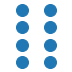

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [125]:
C=RecordingControlWidget(sfdata=SF,recording=X.recording())
display(C)